# Word2Vec + LSTM

# Instalación de librerias

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
#STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
#import plotly.graph_objs as go
#import plotly.plotly as py
#import cufflinks
#from IPython.core.interactiveshell import InteractiveShell
#import plotly.figure_factory as ff
#InteractiveShell.ast_node_interactivity = 'all'
#from plotly.offline import iplot
#cufflinks.go_offline()
#cufflinks.set_config_file(world_readable=True, theme='pearl')
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Cargar el Corpus

In [2]:
df = pd.read_csv("../input/datos01/datos.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8918 entries, 0 to 8917
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   desp_clean_final  8901 non-null   object
 1   INCIBE TAXONOMY   8918 non-null   object
dtypes: object(2)
memory usage: 139.5+ KB


In [4]:
df.head()

,desp_clean_final,INCIBE TAXONOMY
0,compani websit breach sometim around februari ...,HC
1,decemb 29 2011 theft laptop park car san franc...,DL
2,bdo contract rubio perform financi audit servi...,DL
3,februari 10 2012 dhi mortgag becam awar softwa...,HC
4,offic burglari new year eve 2011 result loss h...,DL


In [5]:
print(len(df))

8918


In [6]:
df1 = df.dropna(axis='index',how='any') 

In [7]:
print(len(df))
print(len(df1))

8918
8901


In [8]:
df1.head()

,desp_clean_final,INCIBE TAXONOMY
0,compani websit breach sometim around februari ...,HC
1,decemb 29 2011 theft laptop park car san franc...,DL
2,bdo contract rubio perform financi audit servi...,DL
3,februari 10 2012 dhi mortgag becam awar softwa...,HC
4,offic burglari new year eve 2011 result loss h...,DL


In [9]:
labels = sorted(df1['INCIBE TAXONOMY'].unique())
labels

['DL', 'DOI', 'HC', 'OTHERS', 'PAC', 'THEFT', 'UAI']

In [10]:
df1['INCIBE TAXONOMY'].value_counts() #datos desbalaneceados

HC        2527
DOI       1854
THEFT     1728
DL        1416
OTHERS     702
PAC        606
UAI         68
Name: INCIBE TAXONOMY, dtype: int64

# Visualizacion

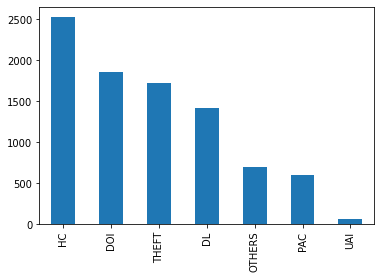

In [11]:
import matplotlib.pyplot as plt
df1['INCIBE TAXONOMY'].value_counts().plot.bar()
plt.show()

# Split Data for Train and Test


Vectorizar la descripción

In [12]:
# Maximo numero de palabras usadas
MAX_NB_WORDS = 50000
# Maximo numero de palabras en cada descripción
MAX_SEQUENCE_LENGTH = 300
# La dimensión del embeding
EMBEDDING_DIM = 200

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df1['desp_clean_final'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 13616 unique tokens.


In [ ]:
print(word_index)

In [13]:
X = tokenizer.texts_to_sequences(df1['desp_clean_final'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (8901, 300)


In [ ]:
print(X[0:3])

In [15]:
Y = pd.get_dummies(df1['INCIBE TAXONOMY']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (8901, 7)


In [16]:
print(Y[0:10])

[[0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0]]


In [17]:
max_length=0
for descp_number in range(len(X)):
  numofwords=len(X[descp_number])
  if(numofwords)>(max_length):
    max_length = numofwords
print(max_length) 

300


In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
data = pad_sequences(X, maxlen = max_length)
y = np.asarray(Y)
print(data)
print('Shape of descriptions tensor: ', data.shape)
print('Shape of label tensor: ', y.shape)

[[   0    0    0 ... 4259   54   24]
 [   0    0    0 ...  453   22    1]
 [   0    0    0 ...    8    4    3]
 ...
 [   0    0    0 ...    2    1   18]
 [   0    0    0 ...    2    1   18]
 [   0    0    0 ...    2    1   18]]
Shape of descriptions tensor:  (8901, 300)
Shape of label tensor:  (8901, 7)


In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(data,y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8010, 300) (8010, 7)
(891, 300) (891, 7)


In [ ]:
#import gensim.downloader as api
#w2v_model = api.load("../input/word2vec/GoogleNews-vectors-negative300.bin")

In [21]:
import tensorflow as tf
from gensim.models import KeyedVectors
from gensim import models

In [22]:
word2vec_path = '../input/word2vec/GoogleNews-vectors-negative300.bin'
w2v_model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [23]:
unique_words = len(word_index)
total_words = unique_words+1
skipped_words = 0
embedding_dim = 300
embedding_matrix = np.zeros((total_words,embedding_dim))
for word, index in tokenizer.word_index.items():
  try:
    embedding_vector = w2v_model[word]
  except:
    skipped_words = skipped_words+1
    pass
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector
print("Embedding Matrix shape: ", embedding_matrix.shape)  

Embedding Matrix shape:  (13617, 300)


In [24]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
embedding_layer = Embedding(total_words, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable = False)

In [25]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Red Neuronal LSTM + capa de embedding con Word2Vec

In [26]:
# LSTM model + Adamax
modelx01 = Sequential()
modelx01.add(embedding_layer)
modelx01.add(LSTM(units=300, use_bias=False, return_sequences=True))
modelx01.add(BatchNormalization())
modelx01.add(Activation('relu'))
modelx01.add(LSTM(units=200,use_bias=False, return_sequences=True))
modelx01.add(BatchNormalization())
modelx01.add(Activation('relu'))
modelx01.add(LSTM(units=100,use_bias=False, return_sequences=False))
modelx01.add(BatchNormalization())
modelx01.add(Activation('relu'))
modelx01.add(Dense(units=7, activation='softmax'))

#modelx01.compile(loss = 'mse', optimizer = 'adamax', metrics=['F1Score'])
# compile the model
#probar con esta funcion de perdida
#categorical_crossentropy 
modelx01.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
print(modelx01.summary())

2022-06-13 14:07:32.818417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 14:07:32.912375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 14:07:32.913198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-13 14:07:32.914925: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          4085100   
_________________________________________________________________
lstm (LSTM)                  (None, 300, 300)          720000    
_________________________________________________________________
batch_normalization (BatchNo (None, 300, 300)          1200      
_________________________________________________________________
activation (Activation)      (None, 300, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 300, 200)          400000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300, 200)          800       
_________________________________________________________________
activation_1 (Activation)    (None, 300, 200)          0

In [27]:
epochs=10
batch_size=16
#histoty_modelx01 = modelx01.fit(X_train,Y_train,epochs=epochs,batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)])

# fit the model
history_modelx01 = modelx01.fit(X_train, Y_train, validation_split=0.3, epochs=epochs, verbose=1,batch_size=batch_size, callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)])

2022-06-13 14:08:22.518749: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
351/351 [==============================] - 570s 2s/step - loss: 1.0172 - accuracy: 0.6356 - f1_m: 0.6156 - precision_m: 0.8482 - recall_m: 0.4932 - val_loss: 1.6129 - val_accuracy: 0.4220 - val_f1_m: 0.0031 - val_precision_m: 0.0265 - val_recall_m: 0.0017
Epoch 2/10
351/351 [==============================] - 566s 2s/step - loss: 0.6890 - accuracy: 0.7649 - f1_m: 0.7528 - precision_m: 0.8895 - recall_m: 0.6593 - val_loss: 0.7494 - val_accuracy: 0.7287 - val_f1_m: 0.7223 - val_precision_m: 0.8189 - val_recall_m: 0.6509
Epoch 3/10
351/351 [==============================] - 565s 2s/step - loss: 0.5443 - accuracy: 0.8217 - f1_m: 0.8144 - precision_m: 0.9028 - recall_m: 0.7459 - val_loss: 0.6636 - val_accuracy: 0.7724 - val_f1_m: 0.7531 - val_precision_m: 0.8603 - val_recall_m: 0.6754
Epoch 4/10
351/351 [==============================] - 567s 2s/step - loss: 0.4364 - accuracy: 0.8564 - f1_m: 0.8504 - precision_m: 0.9168 - recall_m: 0.7970 - val_loss: 0.6070 - val_accuracy: 0.7990 

In [28]:
# evaluate the model
lossx01, accuracyx01, f1_scorex01, precisionx01, recallx01 = modelx01.evaluate(X_test, Y_test, verbose=1)

28/28 [==============================] - 3s 101ms/step - loss: 0.6994 - accuracy: 0.8182 - f1_m: 0.8227 - precision_m: 0.8441 - recall_m: 0.8028


In [29]:
accrx01 = modelx01.evaluate(X_test,Y_test)
print('Test set\n Loss: {:0.4f}\n Accuracy: {:0.4f}\n f1_score: {:0.4f}\n Precision: {:0.4f}\n Recall: {:0.4f}'.format(accrx01[0],accrx01[1],accrx01[2],accrx01[3],accrx01[4]))

28/28 [==============================] - 3s 101ms/step - loss: 0.6994 - accuracy: 0.8182 - f1_m: 0.8227 - precision_m: 0.8441 - recall_m: 0.8028
Test set
 Loss: 0.6994
 Accuracy: 0.8182
 f1_score: 0.8227
 Precision: 0.8441
 Recall: 0.8028


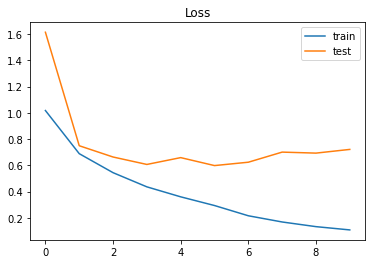

In [30]:
plt.title('Loss')
plt.plot(history_modelx01.history['loss'], label='train')
plt.plot(history_modelx01.history['val_loss'], label='test')
plt.legend()
plt.show();

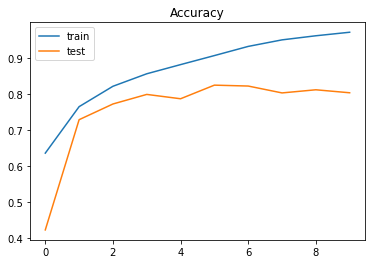

In [31]:
plt.title('Accuracy')
plt.plot(history_modelx01.history['accuracy'], label='train')
plt.plot(history_modelx01.history['val_accuracy'], label='test')
plt.legend()
plt.show();

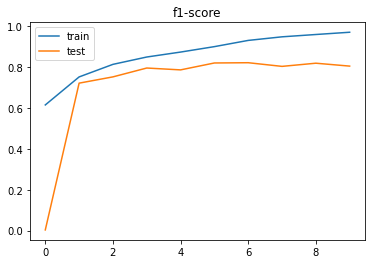

In [32]:
plt.title('f1-score')
plt.plot(history_modelx01.history['f1_m'], label='train')
plt.plot(history_modelx01.history['val_f1_m'], label='test')
plt.legend()
plt.show();

In [33]:
y_pred_01 = np.where(modelx01.predict(X_test)>.5,1,0)

In [47]:
from sklearn import metrics
print(metrics.classification_report(y_pred_01, Y_test,digits=4))

              precision    recall  f1-score   support

           0     0.8125    0.9000    0.8540       130
           1     0.7914    0.7831    0.7872       189
           2     0.8333    0.8730    0.8527       252
           3     0.7746    0.9016    0.8333        61
           4     0.5577    0.7838    0.6517        37
           5     0.8848    0.8249    0.8538       177
           6     0.1250    0.5000    0.2000         2

   micro avg     0.8036    0.8443    0.8235       848
   macro avg     0.6828    0.7952    0.7190       848
weighted avg     0.8136    0.8443    0.8268       848
 samples avg     0.8036    0.8036    0.8036       848



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(33.0, 0.5, 'real')

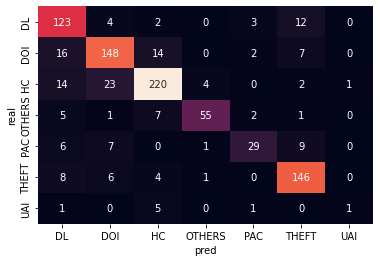

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat_LSTM_W2V01= confusion_matrix(np.asarray(Y_test).argmax(axis=1), np.asarray(y_pred_01).argmax(axis=1))
sns.heatmap(mat_LSTM_W2V01, 
            annot = True, 
            fmt = 'd',
            cbar = False,
            xticklabels = labels,
            yticklabels= labels)
plt.xlabel('pred')
plt.ylabel('real')

# Word2Vec + LSTM + ADAM

In [38]:
# LSTM model + Adam
modelx02 = Sequential()
modelx02.add(embedding_layer)
modelx02.add(LSTM(units=300, use_bias=False, return_sequences=True))
modelx02.add(BatchNormalization())
modelx02.add(Activation('relu'))
modelx02.add(LSTM(units=200,use_bias=False, return_sequences=True))
modelx02.add(BatchNormalization())
modelx02.add(Activation('relu'))
modelx02.add(LSTM(units=100,use_bias=False, return_sequences=False))
modelx02.add(BatchNormalization())
modelx02.add(Activation('relu'))
modelx02.add(Dense(units=7, activation='softmax'))

#modelx01.compile(loss = 'mse', optimizer = 'adamax', metrics=['F1Score'])
# compile the model
#probar con esta funcion de perdida
#categorical_crossentropy 
modelx02.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
print(modelx02.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          4085100   
_________________________________________________________________
lstm_4 (LSTM)                (None, 300, 300)          720000    
_________________________________________________________________
batch_normalization_5 (Batch (None, 300, 300)          1200      
_________________________________________________________________
activation_5 (Activation)    (None, 300, 300)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 300, 200)          400000    
_________________________________________________________________
batch_normalization_6 (Batch (None, 300, 200)          800       
_________________________________________________________________
activation_6 (Activation)    (None, 300, 200)         

In [39]:
epochs=10
batch_size=16
# fit the model
history_modelx02 = modelx02.fit(X_train, Y_train, validation_split=0.3, epochs=epochs, verbose=1,batch_size=batch_size, callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)])

Epoch 1/10
351/351 [==============================] - 559s 2s/step - loss: 0.9275 - accuracy: 0.6742 - f1_m: 0.6523 - precision_m: 0.8605 - recall_m: 0.5368 - val_loss: 1.4431 - val_accuracy: 0.5435 - val_f1_m: 0.2069 - val_precision_m: 0.8118 - val_recall_m: 0.1221
Epoch 2/10
351/351 [==============================] - 554s 2s/step - loss: 0.6815 - accuracy: 0.7744 - f1_m: 0.7674 - precision_m: 0.8784 - recall_m: 0.6868 - val_loss: 0.7591 - val_accuracy: 0.7287 - val_f1_m: 0.7267 - val_precision_m: 0.7889 - val_recall_m: 0.6770
Epoch 3/10
351/351 [==============================] - 554s 2s/step - loss: 0.5763 - accuracy: 0.8118 - f1_m: 0.8061 - precision_m: 0.8863 - recall_m: 0.7437 - val_loss: 0.5980 - val_accuracy: 0.8090 - val_f1_m: 0.8138 - val_precision_m: 0.8778 - val_recall_m: 0.7610
Epoch 4/10
351/351 [==============================] - 559s 2s/step - loss: 0.5048 - accuracy: 0.8361 - f1_m: 0.8294 - precision_m: 0.8926 - recall_m: 0.7781 - val_loss: 0.6747 - val_accuracy: 0.7898 

In [40]:
accrx02 = modelx02.evaluate(X_test,Y_test)
print('Test set\n Loss: {:0.4f}\n Accuracy: {:0.4f}\n f1_score: {:0.4f}\n Precision: {:0.4f}\n Recall: {:0.4f}'.format(accrx02[0],accrx02[1],accrx02[2],accrx02[3],accrx02[4]))

28/28 [==============================] - 3s 119ms/step - loss: 0.6885 - accuracy: 0.8227 - f1_m: 0.8239 - precision_m: 0.8489 - recall_m: 0.8010
Test set
 Loss: 0.6885
 Accuracy: 0.8227
 f1_score: 0.8239
 Precision: 0.8489
 Recall: 0.8010


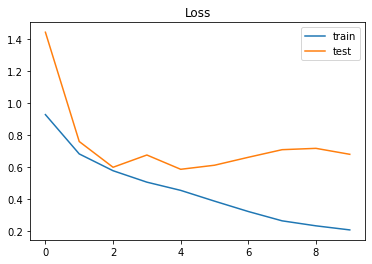

In [41]:
plt.title('Loss')
plt.plot(history_modelx02.history['loss'], label='train')
plt.plot(history_modelx02.history['val_loss'], label='test')
plt.legend()
plt.show();

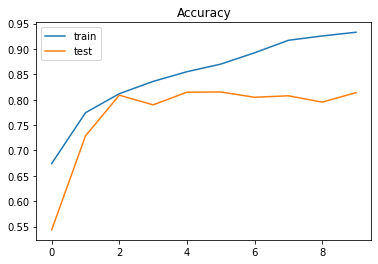

In [42]:
plt.title('Accuracy')
plt.plot(history_modelx02.history['accuracy'], label='train')
plt.plot(history_modelx02.history['val_accuracy'], label='test')
plt.legend()
plt.show();

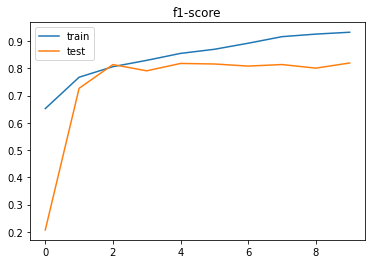

In [43]:
plt.title('f1-score')
plt.plot(history_modelx02.history['f1_m'], label='train')
plt.plot(history_modelx02.history['val_f1_m'], label='test')
plt.legend()
plt.show();

In [44]:
y_pred_02 = np.where(modelx02.predict(X_test)>.5,1,0)

In [46]:
from sklearn import metrics
print(metrics.classification_report(y_pred_02, Y_test,digits=4))

              precision    recall  f1-score   support

           0     0.8333    0.8276    0.8304       145
           1     0.7005    0.8733    0.7774       150
           2     0.8750    0.8717    0.8733       265
           3     0.7606    0.9474    0.8437        57
           4     0.7115    0.6271    0.6667        59
           5     0.8485    0.8537    0.8511       164
           6     0.1250    0.5000    0.2000         2

   micro avg     0.8013    0.8480    0.8240       842
   macro avg     0.6935    0.7858    0.7204       842
weighted avg     0.8106    0.8480    0.8264       842
 samples avg     0.8013    0.8013    0.8013       842



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(33.0, 0.5, 'real')

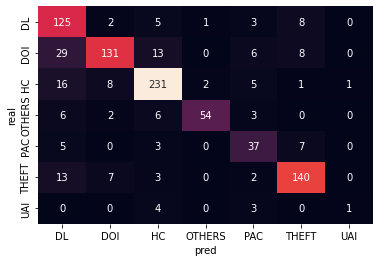

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat_LSTM_W2V02= confusion_matrix(np.asarray(Y_test).argmax(axis=1), np.asarray(y_pred_02).argmax(axis=1))
sns.heatmap(mat_LSTM_W2V02, 
            annot = True, 
            fmt = 'd',
            cbar = False,
            xticklabels = labels,
            yticklabels= labels)
plt.xlabel('pred')
plt.ylabel('real')

# Word2Vec + CNN + Adam

In [49]:
embedding_layer_cnn = Embedding(total_words, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable = False)

In [81]:
# CNN model
modelx03 = Sequential()
modelx03.add(embedding_layer)

modelx03.add(Conv1D(filters=300, kernel_size=7, padding='same', activation='relu'))
modelx03.add(MaxPooling1D(pool_size=3))
modelx03.add(BatchNormalization())
modelx03.add(Activation('relu'))

modelx03.add(Conv1D(filters=100, kernel_size=7, padding='same', activation='relu'))
modelx03.add(MaxPooling1D(pool_size=2))
modelx03.add(BatchNormalization())
modelx03.add(Activation('relu'))

modelx03.add(Flatten())
modelx03.add(Dense(units=10, activation='relu'))
modelx03.add(Dense(units=7, activation='softmax'))

# compile the model
modelx03.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
print(modelx03.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          4085100   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 300, 300)          630300    
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 100, 300)          0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 100, 300)          1200      
_________________________________________________________________
activation_14 (Activation)   (None, 100, 300)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 100, 100)          210100    
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 50, 100)          

In [82]:
epochs=10
batch_size=16
# fit the model
history_modelx03 = modelx03.fit(X_train, Y_train, validation_split=0.3, epochs=epochs, verbose=1,batch_size=batch_size, callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)])

Epoch 1/10
351/351 [==============================] - 5s 11ms/step - loss: 1.0195 - accuracy: 0.6231 - f1_m: 0.6030 - precision_m: 0.8791 - recall_m: 0.4787 - val_loss: 1.0745 - val_accuracy: 0.7416 - val_f1_m: 0.5462 - val_precision_m: 0.9934 - val_recall_m: 0.3860
Epoch 2/10
351/351 [==============================] - 4s 11ms/step - loss: 0.6615 - accuracy: 0.7664 - f1_m: 0.7695 - precision_m: 0.8958 - recall_m: 0.6803 - val_loss: 0.6747 - val_accuracy: 0.7720 - val_f1_m: 0.7578 - val_precision_m: 0.9201 - val_recall_m: 0.6518
Epoch 3/10
351/351 [==============================] - 4s 10ms/step - loss: 0.4826 - accuracy: 0.8300 - f1_m: 0.8283 - precision_m: 0.9046 - recall_m: 0.7681 - val_loss: 0.7886 - val_accuracy: 0.7387 - val_f1_m: 0.7473 - val_precision_m: 0.8217 - val_recall_m: 0.6894
Epoch 4/10
351/351 [==============================] - 4s 11ms/step - loss: 0.3530 - accuracy: 0.8871 - f1_m: 0.8852 - precision_m: 0.9236 - recall_m: 0.8519 - val_loss: 0.7655 - val_accuracy: 0.7824 

In [83]:
# evaluate the model
lossx03, accuracyx03, f1_scorex03, precisionx03, recallx03 = modelx03.evaluate(X_test, Y_test, verbose=1)

28/28 [==============================] - 0s 5ms/step - loss: 1.3000 - accuracy: 0.7475 - f1_m: 0.7491 - precision_m: 0.7667 - recall_m: 0.7327


In [84]:
accrx03 = modelx03.evaluate(X_test,Y_test)
print('Test set\n Loss: {:0.4f}\n Accuracy: {:0.4f}\n f1_score: {:0.4f}\n Precision: {:0.4f}\n Recall: {:0.4f}'.format(accrx03[0],accrx03[1],accrx03[2],accrx03[3],accrx03[4]))

28/28 [==============================] - 0s 5ms/step - loss: 1.3000 - accuracy: 0.7475 - f1_m: 0.7491 - precision_m: 0.7667 - recall_m: 0.7327
Test set
 Loss: 1.3000
 Accuracy: 0.7475
 f1_score: 0.7491
 Precision: 0.7667
 Recall: 0.7327


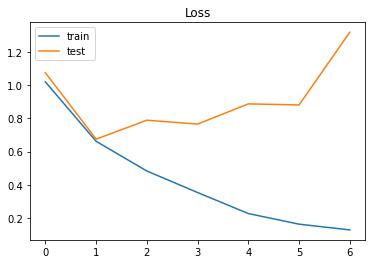

In [85]:
plt.title('Loss')
plt.plot(history_modelx03.history['loss'], label='train')
plt.plot(history_modelx03.history['val_loss'], label='test')
plt.legend()
plt.show();

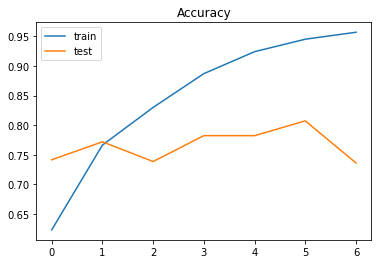

In [86]:
plt.title('Accuracy')
plt.plot(history_modelx03.history['accuracy'], label='train')
plt.plot(history_modelx03.history['val_accuracy'], label='test')
plt.legend()
plt.show();

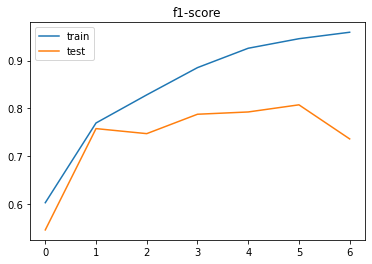

In [87]:
plt.title('f1-score')
plt.plot(history_modelx03.history['f1_m'], label='train')
plt.plot(history_modelx03.history['val_f1_m'], label='test')
plt.legend()
plt.show();

In [88]:
y_pred_03 = np.where(modelx03.predict(X_test)>.5,1,0)

In [90]:
from sklearn import metrics
print(metrics.classification_report(y_pred_03, Y_test,digits=4))

              precision    recall  f1-score   support

           0     0.7292    0.9292    0.8171       113
           1     0.9144    0.5446    0.6826       314
           2     0.6742    0.8856    0.7656       201
           3     0.7606    0.8060    0.7826        67
           4     0.1346    1.0000    0.2373         7
           5     0.8303    0.9257    0.8754       148
           6     0.1250    0.5000    0.2000         2

   micro avg     0.7329    0.7664    0.7493       852
   macro avg     0.5955    0.7987    0.6229       852
weighted avg     0.7982    0.7664    0.7566       852
 samples avg     0.7329    0.7329    0.7329       852



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(33.0, 0.5, 'real')

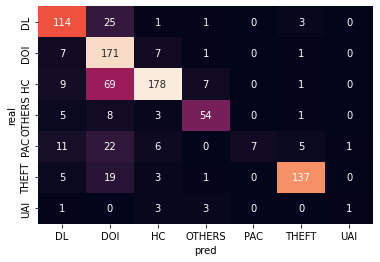

In [91]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat_CNN_W2V01= confusion_matrix(np.asarray(Y_test).argmax(axis=1), np.asarray(y_pred_03).argmax(axis=1))
sns.heatmap(mat_CNN_W2V01, 
            annot = True, 
            fmt = 'd',
            cbar = False,
            xticklabels = labels,
            yticklabels= labels)
plt.xlabel('pred')
plt.ylabel('real')

In [ ]:
#pip freeze (versiones)

# Word2Vec + CNN + ADAMAX

In [71]:
# CNN model + Adamax
modelx04 = Sequential()
modelx04.add(embedding_layer)

modelx04.add(Conv1D(filters=300, kernel_size=7, padding='same', activation='relu'))
modelx04.add(MaxPooling1D(pool_size=3))
modelx04.add(BatchNormalization())
modelx04.add(Activation('relu'))

modelx04.add(Conv1D(filters=100, kernel_size=7, padding='same', activation='relu'))
modelx04.add(MaxPooling1D(pool_size=2))
modelx04.add(BatchNormalization())
modelx04.add(Activation('relu'))

modelx04.add(Flatten())
modelx04.add(Dense(units=10, activation='relu'))
modelx04.add(Dense(units=7, activation='softmax'))

# compile the model
modelx04.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])
print(modelx04.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          4085100   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 300, 300)          630300    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 100, 300)          0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 100, 300)          1200      
_________________________________________________________________
activation_12 (Activation)   (None, 100, 300)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 100, 100)          210100    
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 50, 100)          

In [72]:
epochs=10
batch_size=16
# fit the model
history_modelx04 = modelx04.fit(X_train, Y_train, validation_split=0.3, epochs=epochs, verbose=1,batch_size=batch_size, callbacks=[EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)])

Epoch 1/10
351/351 [==============================] - 5s 11ms/step - loss: 1.0389 - accuracy: 0.6381 - f1_m: 0.6068 - precision_m: 0.9057 - recall_m: 0.4763 - val_loss: 1.2103 - val_accuracy: 0.6721 - val_f1_m: 0.4376 - val_precision_m: 0.9760 - val_recall_m: 0.2890
Epoch 2/10
351/351 [==============================] - 4s 11ms/step - loss: 0.6381 - accuracy: 0.7608 - f1_m: 0.7643 - precision_m: 0.9103 - recall_m: 0.6650 - val_loss: 0.7631 - val_accuracy: 0.7478 - val_f1_m: 0.7103 - val_precision_m: 0.9284 - val_recall_m: 0.5831
Epoch 3/10
351/351 [==============================] - 4s 11ms/step - loss: 0.3493 - accuracy: 0.8917 - f1_m: 0.8827 - precision_m: 0.9405 - recall_m: 0.8351 - val_loss: 0.7113 - val_accuracy: 0.7740 - val_f1_m: 0.7749 - val_precision_m: 0.8492 - val_recall_m: 0.7163
Epoch 4/10
351/351 [==============================] - 4s 11ms/step - loss: 0.1699 - accuracy: 0.9581 - f1_m: 0.9545 - precision_m: 0.9688 - recall_m: 0.9416 - val_loss: 0.7329 - val_accuracy: 0.7715 

In [73]:
# evaluate the model
lossx04, accuracyx04, f1_scorex04, precisionx04, recallx04 = modelx04.evaluate(X_test, Y_test, verbose=1)

28/28 [==============================] - 0s 5ms/step - loss: 0.7401 - accuracy: 0.8058 - f1_m: 0.8146 - precision_m: 0.8386 - recall_m: 0.7928


In [74]:
accrx04 = modelx04.evaluate(X_test,Y_test)
print('Test set\n Loss: {:0.4f}\n Accuracy: {:0.4f}\n f1_score: {:0.4f}\n Precision: {:0.4f}\n Recall: {:0.4f}'.format(accrx04[0],accrx04[1],accrx04[2],accrx04[3],accrx04[4]))

28/28 [==============================] - 0s 5ms/step - loss: 0.7401 - accuracy: 0.8058 - f1_m: 0.8146 - precision_m: 0.8386 - recall_m: 0.7928
Test set
 Loss: 0.7401
 Accuracy: 0.8058
 f1_score: 0.8146
 Precision: 0.8386
 Recall: 0.7928


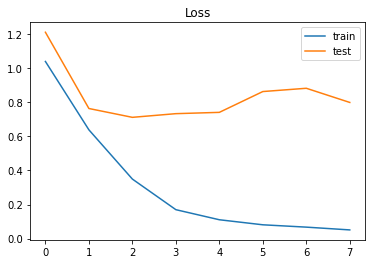

In [75]:
plt.title('Loss')
plt.plot(history_modelx04.history['loss'], label='train')
plt.plot(history_modelx04.history['val_loss'], label='test')
plt.legend()
plt.show();

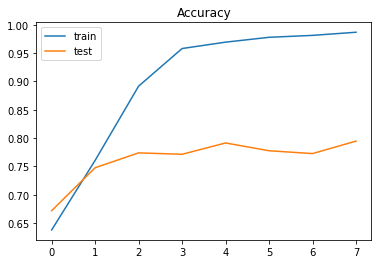

In [76]:
plt.title('Accuracy')
plt.plot(history_modelx04.history['accuracy'], label='train')
plt.plot(history_modelx04.history['val_accuracy'], label='test')
plt.legend()
plt.show();

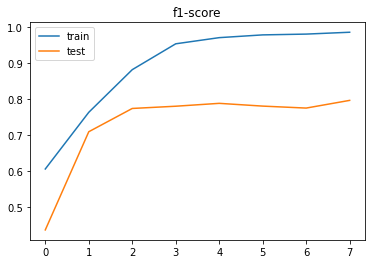

In [77]:
plt.title('f1-score')
plt.plot(history_modelx04.history['f1_m'], label='train')
plt.plot(history_modelx04.history['val_f1_m'], label='test')
plt.legend()
plt.show();

In [78]:
y_pred_04 = np.where(modelx04.predict(X_test)>.5,1,0)

In [79]:
from sklearn import metrics
print(metrics.classification_report(y_pred_04, Y_test,digits=4))

              precision    recall  f1-score   support

           0     0.8333    0.8511    0.8421       141
           1     0.7807    0.7411    0.7604       197
           2     0.8636    0.8231    0.8429       277
           3     0.7465    0.9815    0.8480        54
           4     0.4808    0.7812    0.5952        32
           5     0.8182    0.9441    0.8766       143
           6     0.0000    0.0000    0.0000         0

   micro avg     0.7935    0.8377    0.8150       844
   macro avg     0.6462    0.7317    0.6808       844
weighted avg     0.8095    0.8377    0.8202       844
 samples avg     0.7935    0.7935    0.7935       844



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(33.0, 0.5, 'real')

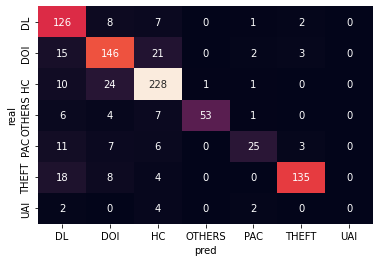

In [80]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat_CNN_W2V02= confusion_matrix(np.asarray(Y_test).argmax(axis=1), np.asarray(y_pred_04).argmax(axis=1))
sns.heatmap(mat_CNN_W2V02, 
            annot = True, 
            fmt = 'd',
            cbar = False,
            xticklabels = labels,
            yticklabels= labels)
plt.xlabel('pred')
plt.ylabel('real')